In [1]:
import glob
import os
import numpy as np
import re
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

txt_file_path = os.getenv('HOME') + '/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])
print(raw_corpus[10:20])

데이터 크기: 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you']
['I would have made you leave your key', 'If I had known for just one second', "You'd be back to bother me Well now go,", 'Walk out the door', 'Just turn around', "Now, you're not welcome anymore Weren't you the one", 'Who tried to break me with desire?', "Did you think I'd crumble?", "Did you think I'd lay down and die? Oh not I,", 'I will survive']


Step 3. 데이터 정제
앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [2]:
line1 = raw_corpus[12]
print(line1)

You'd be back to bother me Well now go,


In [3]:
def preprocess_line(line):
    line = line.lower().strip()
    line = re.sub(r"([?!,.¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', r" ",line)
    line = re.sub(r"[^a-zA-Z?!,.¿]+", r" ", line)
    line = line.strip()
    line = '<start> ' + line + ' <end>'
    return line
#print(preprocess_sentence(line1))

In [4]:
corpus = []
print(len(raw_corpus))

for i in raw_corpus :
    if len(i) == 0:
        continue
    if i[-1] == ":":
        continue
    preprocessed_line = preprocess_line(i)
    corpus.append(preprocessed_line)
corpus[:10]

187088


['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> here without that look upon your face i should have changed that fucking lock <end>']

### generate 'Token box' and fit on it!

In [5]:
tokenizer = Tokenizer(num_words = 12000,
                     oov_token = "<OOV>"
                     )
tokenizer.fit_on_texts(corpus)
print(tokenizer)

### Vectorization : Change preprocessed lines to 'tensor'
1)texts_to_sequences
2)pad_sequences

In [6]:
tensor = tokenizer.texts_to_sequences(corpus)
print(tensor[:5])

## 문장 token 15개 넘는 것 제거!

for line in tensor:
    if len(line) > 15:
        line.pop()
print(len(tensor))
#padding도 간결하게!!

tensor = pad_sequences(tensor,maxlen=15, padding = 'post')

print(tensor.shape)

[[3, 67, 237, 4, 54, 658, 2], [3, 4, 54, 6475, 2], [3, 4, 1088, 528, 4, 100, 75, 201, 254, 6, 2], [3, 118, 12, 295, 34, 90, 4, 1125, 28, 297, 852, 2], [3, 33, 528, 74, 6, 87, 250, 11, 263, 2]]
175749
(175749, 15)


In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <OOV>
2 : end
3 : start
4 : i
5 : the
6 : you
7 : and
8 : a
9 : to
10 : it


In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  3  67 237   4  54 658   2   0   0   0   0   0   0   0]
[ 67 237   4  54 658   2   0   0   0   0   0   0   0   0]


Step 4. 평가 데이터셋 분리
훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [9]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input,
    test_size = 0.2,
    random_state = 20)

### Now, check the result

In [10]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print(enc_val.shape)
print(dec_val.shape)

Source Train: (140599, 14)
Target Train: (140599, 14)
(35150, 14)
(35150, 14)


out:

Source Train: (124960, 14)
Target Train: (124960, 14)

만약 결과가 다르다면 천천히 과정을 다시 살펴 동일한 결과를 얻도록 하세요! 만약 학습 데이터 개수가 124960보다 크다면 위 Step 3.의 데이터 정제 과정을 다시 한번 검토해 보시기를 권합니다.

Step 5. 인공지능 만들기
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요! (Loss는 아래 제시된 Loss 함수를 그대로 사용!)

그리고 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [11]:
BUFFER_SIZE = enc_train.shape[0]
BATCH_SIZE = 1024
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words +1

print(steps_per_epoch,VOCAB_SIZE)

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
BUFFER_SIZE_2 = enc_val.shape[0]

#print(BUFFER_SIZE_2)
valset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
valset = dataset.shuffle(BUFFER_SIZE_2)
valset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(valset)

137 12001
<BatchDataset shapes: ((1024, 14), (1024, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((1024, 1024, 14), (1024, 1024, 14)), types: (tf.int32, tf.int32)>


In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.dropout_1 = tf.keras.layers.Dropout(0.2)
        self.rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
        self.rnn_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
        self.dropout_2 = tf.keras.layers.Dropout(0.2)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.dropout_1(out)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.dropout_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)


In [13]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다

model(src_sample)
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
bidirectional (Bidirectional multiple                  10493952  
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  25174016  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 63,330,273
Trainable params: 63,330,273
Non-trainable params: 0
________________________________________

In [14]:
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
     from_logits=True, reduction='none')

#loss = 'sparse_categorical_crossentropy'

In [15]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

In [16]:
model.compile(loss = loss, optimizer = optimizer)
history = model.fit(dataset,validation_data=(enc_val, dec_val), batch_size = BATCH_SIZE, callbacks=[checkpoint], epochs = 10)

Epoch 1/10
137/137 [==============================] - 401s 3s/step - loss: 4.4256 - val_loss: 3.0157

Epoch 00001: val_loss improved from inf to 3.01571, saving model to my_checkpoint.ckpt
Epoch 2/10
137/137 [==============================] - 398s 3s/step - loss: 2.2522 - val_loss: 0.6350

Epoch 00002: val_loss improved from 3.01571 to 0.63500, saving model to my_checkpoint.ckpt
Epoch 3/10
137/137 [==============================] - 397s 3s/step - loss: 0.4991 - val_loss: 0.2888

Epoch 00003: val_loss improved from 0.63500 to 0.28878, saving model to my_checkpoint.ckpt
Epoch 4/10
137/137 [==============================] - 397s 3s/step - loss: 0.2076 - val_loss: 0.1824

Epoch 00004: val_loss improved from 0.28878 to 0.18240, saving model to my_checkpoint.ckpt
Epoch 5/10
137/137 [==============================] - 396s 3s/step - loss: 0.1060 - val_loss: 0.1370

Epoch 00005: val_loss improved from 0.18240 to 0.13703, saving model to my_checkpoint.ckpt
Epoch 6/10
137/137 [===================

In [26]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    enc_val
    end_token = tokenizer.word_index["end"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [27]:
model.load_weights(checkpoint_path)

In [33]:
generate_text(model, tokenizer, init_sentence="<start> i love ", max_len=20)

'start i love you so much older older older la la la la la la la end '

### Finally, submit a line of lyrics the model generated.

i love you so much older older older la la la la la la la

## What i did for less loss
### 1) adjusted batch size and hidden size
### 2) Try to check the validation loss with checkpoint and print!
### 3) Change model
  - add bidirectional layer in RNN layer
  - add 2 Dropout layer 

## +Bonus, plot loss and val_loss 

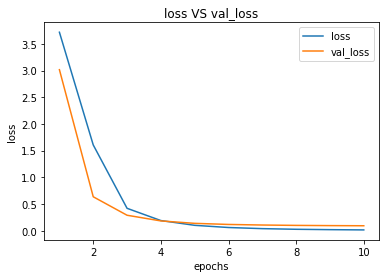

In [41]:
import matplotlib.pyplot as plt

epochs = 10
fig = plt.figure()

plt.plot(np.arange(1,epochs + 1),history.history['loss'])
plt.plot(np.arange(1,epochs + 1),history.history['val_loss'])
plt.title('loss VS val_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss','val_loss'])
plt.show()